In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "3"

In [2]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.utils.data import Subset

def subsample_dataset(dataset, num_samples, seed=42):
    torch.manual_seed(seed)
    indices = torch.randperm(len(dataset))[:num_samples]
    return Subset(dataset, indices)

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

full_train_dataset = datasets.MNIST(
    root="./data",
    train=True,
    download=True,
    transform=transform
)

test_dataset = datasets.MNIST(
    root="./data",
    train=False,
    download=True,
    transform=transform
)

# 5,000개만 사용
train_dataset_small = subsample_dataset(
    full_train_dataset,
    num_samples=5000,
    seed=42
)

train_loader = DataLoader(
    train_dataset_small,
    batch_size=128,
    shuffle=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=256,
    shuffle=False
)

In [4]:
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm 

In [5]:
class CNN_MNIST(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 8, 3, padding=1),   # 32 → 8
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(8, 16, 3, padding=1), # 64 → 16
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Linear(16 * 7 * 7, 10)

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        return self.classifier(x)

class MLP_MNIST(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(28 * 28, 128),  # 512 → 128
            nn.ReLU(),
            nn.Linear(128, 64),       # 256 → 64
            nn.ReLU(),
            nn.Linear(64, 10)
        )

    def forward(self, x):
        x = x.view(x.size(0), -1)
        return self.net(x)

In [6]:
import copy

def fine_tune(model, optimizer, criterion, train_loader, device):
    model.train()
    train_loss = 0.0

    for x, y in train_loader:
        x = x.to(device)
        y = y.to(device)

        optimizer.zero_grad()
        outputs = model(x)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    return (
        model,
        copy.deepcopy(model.state_dict()),
        train_loss / len(train_loader)
    )

In [7]:
ce_loss = nn.CrossEntropyLoss()
kl_loss = nn.KLDivLoss(reduction="batchmean")

In [8]:
def kd_loss(student_logits, teacher_logits, T=2.0):
    return kl_loss(
        F.log_softmax(student_logits / T, dim=1),
        F.softmax(teacher_logits / T, dim=1)
    ) * (T * T)

def studygroup(
    model1,
    model2,
    optimizer1,
    optimizer2,
    train_loader,
    device,
    T=2.0
):
    model1.train()
    model2.train()

    train_loss1 = 0.0
    train_loss2 = 0.0

    for x, y in train_loader:
        x = x.to(device)
        y = y.to(device)

        optimizer1.zero_grad()
        optimizer2.zero_grad()

        logits1 = model1(x)
        logits2 = model2(x)

        pred1 = logits1.argmax(dim=1)
        pred2 = logits2.argmax(dim=1)

        correct1 = pred1 == y
        correct2 = pred2 == y

        # index 정의
        index1 = correct1 & ~correct2   # model1 
        index2 = ~correct1 & correct2   # model2 
        index3 = ~(index1 | index2)    

        # ----------------------
        # model1 update
        # ----------------------
        loss1 = 0.0
        if index2.any():
            loss1 += kd_loss(
                logits1[index2],
                logits2[index2].detach(),
                T=T
            )
        if index3.any():
            loss1 += ce_loss(
                logits1[index3],
                y[index3]
            )

        loss1.backward()
        optimizer1.step()

        # ----------------------
        # model2 update
        # ----------------------
        loss2 = 0.0
        if index1.any():
            loss2 += kd_loss(
                logits2[index1],
                logits1[index1].detach(),
                T=T
            )
        if index3.any():
            loss2 += ce_loss(
                logits2[index3],
                y[index3]
            )

        loss2.backward()
        optimizer2.step()

        train_loss1 += loss1.item()
        train_loss2 += loss2.item()

    return (
        model1,
        model2,
        copy.deepcopy(model1.state_dict()),
        copy.deepcopy(model2.state_dict()),
        train_loss1 / len(train_loader),
        train_loss2 / len(train_loader)
    )

def evaluate(model, test_loader, device):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for x, y in test_loader:
            x = x.to(device)
            y = y.to(device)

            outputs = model(x)
            preds = outputs.argmax(dim=1)

            correct += (preds == y).sum().item()
            total += y.size(0)

    return correct / total


In [9]:
from tqdm.notebook import tqdm

def train_baseline(
    model,
    optimizer,
    criterion,
    train_loader,
    test_loader,
    device,
    epochs,
    log_dict
):
    for epoch in tqdm(range(epochs)):
        model, _, train_loss = fine_tune(
            model,
            optimizer,
            criterion,
            train_loader,
            device
        )

        test_acc = evaluate(model, test_loader, device)

        log_dict["train_loss"].append(train_loss)
        log_dict["test_acc"].append(test_acc)

        print(
            f"[Baseline][{epoch:02d}] "
            f"Loss={train_loss:.4f}, Acc={test_acc:.4f}"
        )

def train_studygroup(
    model1,
    model2,
    optimizer1,
    optimizer2,
    train_loader,
    test_loader,
    device,
    epochs,
    log1,
    log2,
    T=2.0
):
    for epoch in tqdm(range(epochs)):
        model1, model2, _, _, loss1, loss2 = studygroup(
            model1,
            model2,
            optimizer1,
            optimizer2,
            train_loader,
            device,
            T=T
        )

        acc1 = evaluate(model1, test_loader, device)
        acc2 = evaluate(model2, test_loader, device)

        log1["train_loss"].append(loss1)
        log1["test_acc"].append(acc1)

        log2["train_loss"].append(loss2)
        log2["test_acc"].append(acc2)

        print(
            f"[Studygroup][{epoch:02d}] "
            f"CNN Loss={loss1:.4f}, Acc={acc1:.4f} | "
            f"MLP Loss={loss2:.4f}, Acc={acc2:.4f}"
        )


In [10]:
def init_log():
    return {
        "train_loss": [],
        "test_acc": []
    }
logs = {
    "baseline_cnn": init_log(),
    "baseline_mlp": init_log(),
    "studygroup_cnn": init_log(),
    "studygroup_mlp": init_log(),
    "individual_cnn1": init_log(),
    "individual_mlp1": init_log(),
    "individual_cnn2": init_log(),
    "individual_mlp2": init_log(),
}

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
epochs = 500
criterion = nn.CrossEntropyLoss()

cnn_master = CNN_MNIST().to(device)
mlp_master = MLP_MNIST().to(device)

cnn_init_state = copy.deepcopy(cnn_master.state_dict())
mlp_init_state = copy.deepcopy(mlp_master.state_dict())

In [12]:
cnn_base = CNN_MNIST().to(device)
cnn_base.load_state_dict(cnn_init_state)
opt_cnn_base = torch.optim.Adam(cnn_base.parameters(), lr=1e-3)

train_baseline(
    cnn_base,
    opt_cnn_base,
    criterion,
    train_loader,
    test_loader,
    device,
    epochs,
    logs["baseline_cnn"]
)

mlp_base = MLP_MNIST().to(device)
mlp_base.load_state_dict(mlp_init_state)
opt_mlp_base = torch.optim.Adam(mlp_base.parameters(), lr=1e-3)

train_baseline(
    mlp_base,
    opt_mlp_base,
    criterion,
    train_loader,
    test_loader,
    device,
    epochs,
    logs["baseline_mlp"]
)


  0%|          | 0/500 [00:00<?, ?it/s]

[Baseline][00] Loss=1.4048, Acc=0.8192
[Baseline][01] Loss=0.4482, Acc=0.9050
[Baseline][02] Loss=0.3041, Acc=0.9260
[Baseline][03] Loss=0.2350, Acc=0.9400
[Baseline][04] Loss=0.1938, Acc=0.9464
[Baseline][05] Loss=0.1599, Acc=0.9525
[Baseline][06] Loss=0.1380, Acc=0.9543
[Baseline][07] Loss=0.1290, Acc=0.9579
[Baseline][08] Loss=0.1095, Acc=0.9581
[Baseline][09] Loss=0.0977, Acc=0.9647
[Baseline][10] Loss=0.0887, Acc=0.9647
[Baseline][11] Loss=0.0845, Acc=0.9586
[Baseline][12] Loss=0.0779, Acc=0.9642
[Baseline][13] Loss=0.0697, Acc=0.9672
[Baseline][14] Loss=0.0622, Acc=0.9671
[Baseline][15] Loss=0.0551, Acc=0.9684
[Baseline][16] Loss=0.0504, Acc=0.9691
[Baseline][17] Loss=0.0456, Acc=0.9662
[Baseline][18] Loss=0.0454, Acc=0.9689
[Baseline][19] Loss=0.0379, Acc=0.9705
[Baseline][20] Loss=0.0329, Acc=0.9712
[Baseline][21] Loss=0.0328, Acc=0.9694
[Baseline][22] Loss=0.0409, Acc=0.9668
[Baseline][23] Loss=0.0262, Acc=0.9673
[Baseline][24] Loss=0.0242, Acc=0.9728
[Baseline][25] Loss=0.020

  0%|          | 0/500 [00:00<?, ?it/s]

[Baseline][00] Loss=1.0963, Acc=0.8694
[Baseline][01] Loss=0.3952, Acc=0.8970
[Baseline][02] Loss=0.3055, Acc=0.9074
[Baseline][03] Loss=0.2726, Acc=0.9096
[Baseline][04] Loss=0.2284, Acc=0.9232
[Baseline][05] Loss=0.1733, Acc=0.9239
[Baseline][06] Loss=0.1618, Acc=0.9265
[Baseline][07] Loss=0.1501, Acc=0.9267
[Baseline][08] Loss=0.1414, Acc=0.9304
[Baseline][09] Loss=0.1311, Acc=0.9321
[Baseline][10] Loss=0.0991, Acc=0.9351
[Baseline][11] Loss=0.0844, Acc=0.9385
[Baseline][12] Loss=0.0563, Acc=0.9400
[Baseline][13] Loss=0.0492, Acc=0.9314
[Baseline][14] Loss=0.0610, Acc=0.9356
[Baseline][15] Loss=0.0402, Acc=0.9358
[Baseline][16] Loss=0.0563, Acc=0.9397
[Baseline][17] Loss=0.0254, Acc=0.9410
[Baseline][18] Loss=0.0183, Acc=0.9381
[Baseline][19] Loss=0.0162, Acc=0.9384
[Baseline][20] Loss=0.0142, Acc=0.9409
[Baseline][21] Loss=0.0117, Acc=0.9419
[Baseline][22] Loss=0.0102, Acc=0.9424
[Baseline][23] Loss=0.0091, Acc=0.9415
[Baseline][24] Loss=0.0081, Acc=0.9415
[Baseline][25] Loss=0.008

In [13]:
cnn_sg = CNN_MNIST().to(device)
cnn_sg.load_state_dict(cnn_init_state)
mlp_sg = MLP_MNIST().to(device)
mlp_sg.load_state_dict(mlp_init_state)

opt_cnn_sg = torch.optim.Adam(cnn_sg.parameters(), lr=1e-3)
opt_mlp_sg = torch.optim.Adam(mlp_sg.parameters(), lr=1e-3)

train_studygroup(
    cnn_sg,
    mlp_sg,
    opt_cnn_sg,
    opt_mlp_sg,
    train_loader,
    test_loader,
    device,
    epochs,
    logs["studygroup_cnn"],
    logs["studygroup_mlp"],
    T=2.0
)


  0%|          | 0/500 [00:00<?, ?it/s]

[Studygroup][00] CNN Loss=1.6239, Acc=0.8382 | MLP Loss=1.3918, Acc=0.8458
[Studygroup][01] CNN Loss=0.7202, Acc=0.8885 | MLP Loss=0.7296, Acc=0.8575
[Studygroup][02] CNN Loss=0.5839, Acc=0.9118 | MLP Loss=0.6108, Acc=0.8975
[Studygroup][03] CNN Loss=0.5947, Acc=0.9239 | MLP Loss=0.6372, Acc=0.8948
[Studygroup][04] CNN Loss=0.5301, Acc=0.9313 | MLP Loss=0.5235, Acc=0.9130
[Studygroup][05] CNN Loss=0.4751, Acc=0.9296 | MLP Loss=0.5042, Acc=0.9106
[Studygroup][06] CNN Loss=0.5239, Acc=0.9284 | MLP Loss=0.5648, Acc=0.9083
[Studygroup][07] CNN Loss=0.4768, Acc=0.9433 | MLP Loss=0.5521, Acc=0.9212
[Studygroup][08] CNN Loss=0.4876, Acc=0.9433 | MLP Loss=0.5642, Acc=0.9156
[Studygroup][09] CNN Loss=0.4012, Acc=0.9475 | MLP Loss=0.5182, Acc=0.9200
[Studygroup][10] CNN Loss=0.4302, Acc=0.9502 | MLP Loss=0.5317, Acc=0.9265
[Studygroup][11] CNN Loss=0.5181, Acc=0.9547 | MLP Loss=0.5064, Acc=0.9199
[Studygroup][12] CNN Loss=0.4810, Acc=0.9515 | MLP Loss=0.5433, Acc=0.9270
[Studygroup][13] CNN Loss

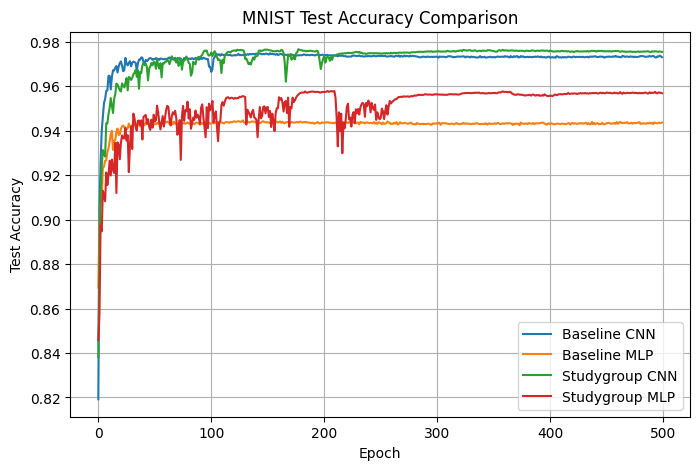

In [14]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 5))

plt.plot(logs["baseline_cnn"]["test_acc"], label="Baseline CNN")
plt.plot(logs["baseline_mlp"]["test_acc"], label="Baseline MLP")
plt.plot(logs["studygroup_cnn"]["test_acc"], label="Studygroup CNN")
plt.plot(logs["studygroup_mlp"]["test_acc"], label="Studygroup MLP")

plt.xlabel("Epoch")
plt.ylabel("Test Accuracy")
plt.legend()
plt.grid(True)
plt.title("MNIST Test Accuracy Comparison")
plt.show()


In [15]:
print(max(logs["baseline_cnn"]["test_acc"]))
print(max(logs["baseline_mlp"]["test_acc"]))
print(max(logs["studygroup_cnn"]["test_acc"]))
print(max(logs["studygroup_mlp"]["test_acc"]))

0.9749
0.9447
0.9767
0.9579


In [16]:
cnn_id1 = CNN_MNIST().to(device)
cnn_id1.load_state_dict(cnn_init_state)
cnn_id2 = CNN_MNIST().to(device)
cnn_id2.load_state_dict(cnn_init_state)

opt_cnn_id1 = torch.optim.Adam(cnn_id1.parameters(), lr=1e-3)
opt_cnn_id2 = torch.optim.Adam(cnn_id2.parameters(), lr=1e-3)

train_studygroup(
    cnn_id1,
    cnn_id2,
    opt_cnn_id1,
    opt_cnn_id2,
    train_loader,
    test_loader,
    device,
    epochs,
    logs["individual_cnn1"],
    logs["individual_cnn2"],
    T=2.0
)


  0%|          | 0/500 [00:00<?, ?it/s]

[Studygroup][00] CNN Loss=1.4297, Acc=0.8410 | MLP Loss=1.4297, Acc=0.8410
[Studygroup][01] CNN Loss=0.4712, Acc=0.9037 | MLP Loss=0.4712, Acc=0.9037
[Studygroup][02] CNN Loss=0.3004, Acc=0.9198 | MLP Loss=0.3004, Acc=0.9198
[Studygroup][03] CNN Loss=0.2436, Acc=0.9366 | MLP Loss=0.2436, Acc=0.9366
[Studygroup][04] CNN Loss=0.1991, Acc=0.9414 | MLP Loss=0.1991, Acc=0.9415
[Studygroup][05] CNN Loss=0.1758, Acc=0.9497 | MLP Loss=0.1758, Acc=0.9498
[Studygroup][06] CNN Loss=0.1501, Acc=0.9565 | MLP Loss=0.1501, Acc=0.9566
[Studygroup][07] CNN Loss=0.1695, Acc=0.9373 | MLP Loss=0.1835, Acc=0.9158
[Studygroup][08] CNN Loss=0.6997, Acc=0.9423 | MLP Loss=0.6366, Acc=0.9539
[Studygroup][09] CNN Loss=0.3644, Acc=0.9604 | MLP Loss=0.3138, Acc=0.9590
[Studygroup][10] CNN Loss=0.2693, Acc=0.9542 | MLP Loss=0.2220, Acc=0.9526
[Studygroup][11] CNN Loss=0.2746, Acc=0.9595 | MLP Loss=0.2533, Acc=0.9612
[Studygroup][12] CNN Loss=0.2316, Acc=0.9612 | MLP Loss=0.2779, Acc=0.9588
[Studygroup][13] CNN Loss

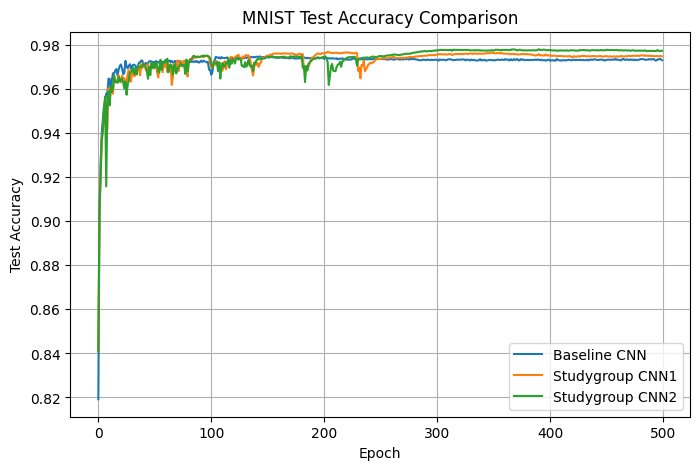

In [17]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 5))

plt.plot(logs["baseline_cnn"]["test_acc"], label="Baseline CNN")
plt.plot(logs["individual_cnn1"]["test_acc"], label="Studygroup CNN1")
plt.plot(logs["individual_cnn2"]["test_acc"], label="Studygroup CNN2")

plt.xlabel("Epoch")
plt.ylabel("Test Accuracy")
plt.legend()
plt.grid(True)
plt.title("MNIST Test Accuracy Comparison")
plt.show()


In [18]:
print(max(logs["baseline_cnn"]["test_acc"]))
print(max(logs["individual_cnn1"]["test_acc"]))
print(max(logs["individual_cnn2"]["test_acc"]))

0.9749
0.9769
0.9781


In [19]:
mlp_id1 = MLP_MNIST().to(device)
mlp_id1.load_state_dict(mlp_init_state)
mlp_id2 = MLP_MNIST().to(device)
mlp_id2.load_state_dict(mlp_init_state)

opt_mlp_id1 = torch.optim.Adam(mlp_id1.parameters(), lr=1e-3)
opt_mlp_id2 = torch.optim.Adam(mlp_id2.parameters(), lr=1e-3)

train_studygroup(
    mlp_id1,
    mlp_id2,
    opt_mlp_id1,
    opt_mlp_id2,
    train_loader,
    test_loader,
    device,
    epochs,
    logs["individual_mlp1"],
    logs["individual_mlp2"],
    T=2.0
)

  0%|          | 0/500 [00:00<?, ?it/s]

[Studygroup][00] CNN Loss=1.0805, Acc=0.8414 | MLP Loss=1.0805, Acc=0.8414
[Studygroup][01] CNN Loss=0.4079, Acc=0.9014 | MLP Loss=0.4079, Acc=0.9014
[Studygroup][02] CNN Loss=0.2997, Acc=0.9099 | MLP Loss=0.2997, Acc=0.9099
[Studygroup][03] CNN Loss=0.2519, Acc=0.9163 | MLP Loss=0.2519, Acc=0.9163
[Studygroup][04] CNN Loss=0.2114, Acc=0.9203 | MLP Loss=0.2114, Acc=0.9203
[Studygroup][05] CNN Loss=0.1684, Acc=0.9219 | MLP Loss=0.1684, Acc=0.9219
[Studygroup][06] CNN Loss=0.1502, Acc=0.9277 | MLP Loss=0.1502, Acc=0.9277
[Studygroup][07] CNN Loss=0.1247, Acc=0.9346 | MLP Loss=0.1247, Acc=0.9346
[Studygroup][08] CNN Loss=0.1067, Acc=0.9283 | MLP Loss=0.1067, Acc=0.9283
[Studygroup][09] CNN Loss=0.0970, Acc=0.9334 | MLP Loss=0.0970, Acc=0.9334
[Studygroup][10] CNN Loss=0.0710, Acc=0.9381 | MLP Loss=0.0710, Acc=0.9381
[Studygroup][11] CNN Loss=0.0564, Acc=0.9361 | MLP Loss=0.0564, Acc=0.9361
[Studygroup][12] CNN Loss=0.0505, Acc=0.9358 | MLP Loss=0.0505, Acc=0.9358
[Studygroup][13] CNN Loss

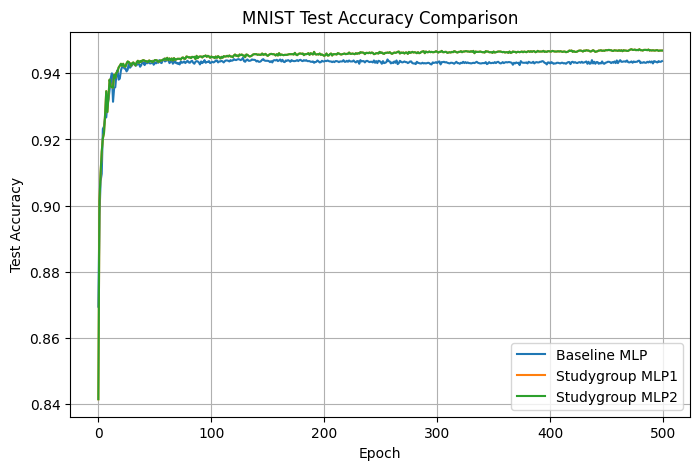

In [20]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 5))

plt.plot(logs["baseline_mlp"]["test_acc"], label="Baseline MLP")
plt.plot(logs["individual_mlp1"]["test_acc"], label="Studygroup MLP1")
plt.plot(logs["individual_mlp2"]["test_acc"], label="Studygroup MLP2")

plt.xlabel("Epoch")
plt.ylabel("Test Accuracy")
plt.legend()
plt.grid(True)
plt.title("MNIST Test Accuracy Comparison")
plt.show()


In [21]:
print(max(logs["baseline_mlp"]["test_acc"]))
print(max(logs["individual_mlp1"]["test_acc"]))
print(max(logs["individual_mlp2"]["test_acc"]))

0.9447
0.9473
0.9473


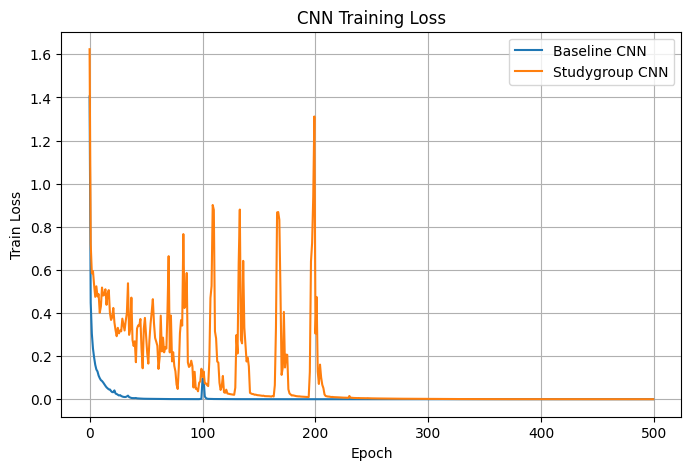

In [22]:
plt.figure(figsize=(8, 5))

plt.plot(logs["baseline_cnn"]["train_loss"], label="Baseline CNN")
plt.plot(logs["studygroup_cnn"]["train_loss"], label="Studygroup CNN")

plt.xlabel("Epoch")
plt.ylabel("Train Loss")
plt.legend()
plt.grid(True)
plt.title("CNN Training Loss")
plt.show()
